In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

##### **I will be training a ResNet34 model on the Fish Dataset using Pytorch. This notebook is in an explanatory form so it will be easy for everyone to understand.**

# Imports and downloads

In [2]:
import torch
import torchvision
from torchvision import models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

import tarfile
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split

import albumentations as A

from albumentations.pytorch import ToTensorV2

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install albumentations==0.4.6

     |████████████████████████████████| 117 kB 1.3 MB/s eta 0:00:01
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65161 sha256=64b32e057e86e969dd4854f72bea509b2ecb8289fae99a218e56d8433471e13a
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.5.2
    Uninstalling albumentations-0.5.2:
      Successfully uninstalled albumentations-0.5.2


# Data Cleaning
#### We will first try to separate the images from the GT images in the folders for each class and use their titles to create our labels.

In [4]:
root_dir = '../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'
path = Path(root_dir)
path_images = list(path.glob('**/*.png'))

images_paths = [str(path_image) for path_image in path_images if 'GT' not in str(path_image)]
print(f'Number of training images :{len(images_paths)}')

labels = [os.path.split(os.path.split(name)[0])[1] for name in images_paths]
print(f'Number of labels :{len(labels)}')

Number of training images :9000
Number of labels :9000


#### The labels must be converted into numbers to make it easier to work with for our model.

In [5]:
classes = list(set(labels))
labels_dict = {label : i for i,label in enumerate(classes)}
labels_val = [labels_dict[label_key] for label_key in labels]

#### Lets see the number of classes and what they are.

In [6]:
print("No. of classes:", len(classes))
print("Various Classes:", classes)

No. of classes: 9
Various Classes: ['Sea Bass', 'Hourse Mackerel', 'Black Sea Sprat', 'Red Mullet', 'Trout', 'Gilt-Head Bream', 'Striped Red Mullet', 'Red Sea Bream', 'Shrimp']


# Generating Train, Test and Validation Datasets

#### Let us split the data first...

In [7]:
random_seed = 42
torch.manual_seed(random_seed);

In [8]:
#Splitting test data from the whole dataset
data, test_data, labels, test_labels = train_test_split(images_paths, labels_val, test_size=0.15, shuffle=True)
#Splitting train data and validation data
train_data, val_data, train_labels, val_labels = train_test_split(data, labels, test_size=0.1, shuffle=True)

#### The class `FishDataset()` below will be useful in creating the datasets further down the line.

In [9]:
class FishDataset(torch.utils.data.Dataset):
    def __init__(self, images: list, labels: list, transform=None):
        super().__init__()
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self, ):
        return len(self.labels)

    def __getitem__(self, index):
        input_image = self.images[index]
        label = self.labels[index]
        image = np.array(Image.open(input_image).convert("RGB"))

        if self.transform is not None:
            augmentations = self.transform(image=image)
            image = augmentations["image"]

        return image, label

#### Using albumentations to perform some image manipulations to make our model generalize better. We will use these transforms later while making the datasets.

In [10]:
train_transforms = A.Compose(
    [
        A.Resize(height=160, width=240),
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

val_transforms = A.Compose(
    [
        A.Resize(height=160, width=240),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

#### The train, test and validation datasets can be created as shown below.

In [11]:
train_ds = FishDataset(images=train_data,labels=train_labels,transform=train_transforms)

val_ds = FishDataset(images=val_data,labels=val_labels,transform=val_transforms)

test_ds = FishDataset(images=test_data,labels=test_labels,transform=val_transforms)

#### We will convert these datasets into dataloaders which will pass image samples in “minibatches" and reshuffle the data at every epoch to reduce model overfitting.

In [12]:
BATCH_SIZE = 128

train_loader = DataLoader(train_ds,batch_size=BATCH_SIZE,num_workers=4,pin_memory=True,shuffle=True)   

val_loader = DataLoader(val_ds,batch_size=BATCH_SIZE,num_workers=4,pin_memory=True)

test_loader = DataLoader(test_ds,batch_size=BATCH_SIZE,num_workers=4,pin_memory=True)

# Creating Our Model

#### We will now create a `FishModel()` class which will import the pretrained model for us and create a working model for our dataset. It also has a bunch of helper functions.

In [13]:
class FishModel(nn.Module):
    
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        self.network = models.resnet34(pretrained=pretrained)
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {}, val_loss: {}, val_acc: {}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))



#### Here I created more helper functions which will be useful in fitting the data to the model and then evaluating the model performance afterwards. The `fit_one_cycle()` function takes in the number of epochs, our model, our dataloaders and optimization functions.

In [14]:
def accuracy(outputs, labels):
        _, preds = torch.max(outputs, dim=1)
        return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [15]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

# Training on GPU

#### We will now check the availability of GPU and if available move the data and the model on it. These functions will be useful in doing so.

In [16]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


#### To check the availability of the GPU

In [17]:
device = get_default_device()
device

device(type='cuda')

#### Now, as the GPU is available, we will move the data on it.

In [18]:
train_dl = DeviceDataLoader(train_loader, device)
valid_dl = DeviceDataLoader(val_loader, device)

#### After loading the data on the GPU we will send our model on the GPU after instantiating it from our `FishModel()` class. The `len(classes)` is the number of classes which will generate a linear layer for 9 classes at the end of our pretrained model.

In [19]:
model = FishModel(len(classes))
to_device(model, device);

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

#### We will now check for the accuracy and losses by the model without any training.

In [20]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.456782817840576, 'val_acc': 0.12292709201574326}]

# Model Training
#### Mentioning some hyperparameters before calling the fit_one_cycle() function.

In [21]:
epochs = 6
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

#### Begin training...

In [22]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [0],last_lr: 0.00596, train_loss: 0.38011255860328674, val_loss: 578.192138671875, val_acc: 0.10717707872390747


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [1],last_lr: 0.00994, train_loss: 0.3608550727367401, val_loss: 25.896209716796875, val_acc: 0.2486458271741867


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.00812, train_loss: 0.24963808059692383, val_loss: 1.502174735069275, val_acc: 0.6577916741371155


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [3],last_lr: 0.00463, train_loss: 0.0408831387758255, val_loss: 0.1541007161140442, val_acc: 0.9476354122161865


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [4],last_lr: 0.00133, train_loss: 0.008193316869437695, val_loss: 0.14649251103401184, val_acc: 0.9397916793823242


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [5],last_lr: 0.00000, train_loss: 0.002655074931681156, val_loss: 0.011105048470199108, val_acc: 0.9973958134651184
CPU times: user 58.3 s, sys: 22.5 s, total: 1min 20s
Wall time: 7min 59s


# Model Testing

#### Now that our model is trained we will start with the testing and evaluation of our model.

In [23]:
def eval_accuracy(loader):  
    model.eval()
    corrects = 0
    total = 0
    for images, labels in loader:
        images, labels = to_device(images, device), to_device(labels, device)
        predictions = model(images)
        predict = to_device(torch.max(predictions.data, 1)[1], device)
        total += len(labels)
        corrects += (predict == labels).sum()
    accuracy = 100 * corrects / float(total)
    return accuracy

In [24]:
test_acc = eval_accuracy(test_loader)
print(f' Accuracy on test images: {test_acc}')

 Accuracy on test images: 99.40740966796875


#### The function `predict_image()` takes in test images, sends it to the device (i.e. GPU) and let our model predict it. This will generate a list of probabilities for each class and the function returns the class with the highest probability.

In [25]:
def predict_image(image):
    xb = to_device(image.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return classes[preds[0].item()]

#### Testing some random images individually.

Label: Gilt-Head Bream , Predicted: Gilt-Head Bream


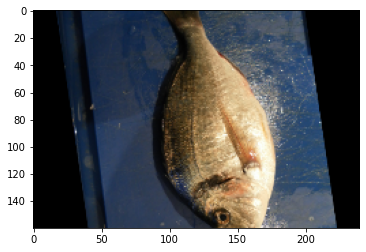

In [26]:
img, label = test_ds[100]
plt.imshow(img.permute(1, 2, 0))
print('Label:', classes[label], ', Predicted:', predict_image(img))


Label: Red Sea Bream , Predicted: Red Sea Bream


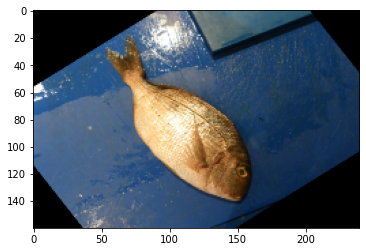

In [27]:
img, label = test_ds[500]
plt.imshow(img.permute(1, 2, 0))
print('Label:', classes[label], ', Predicted:', predict_image(img))

Label: Striped Red Mullet , Predicted: Striped Red Mullet


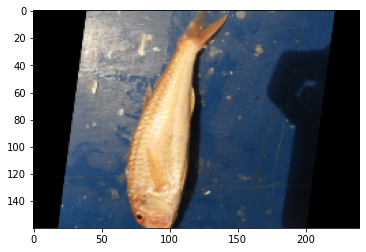

In [28]:
img, label = test_ds[800]
plt.imshow(img.permute(1, 2, 0))
print('Label:', classes[label], ', Predicted:', predict_image(img))

#  So how well did our model perform?

In [29]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

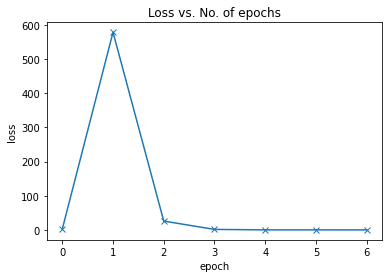

In [30]:
plot_losses(history)

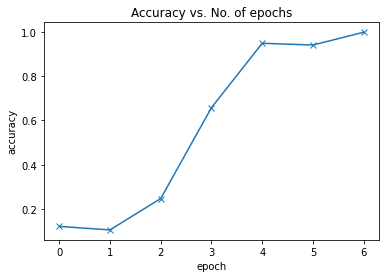

In [31]:
plot_accuracies(history)

In [32]:
print("We used a RESNET34 model to predict and classify fish images and achieved a test accuracy of {:.2f}%.".format(test_acc))



We used a RESNET34 model to predict and classify fish images and achieved a test accuracy of 99.41%.


#### We can try to further improve this by changing the batch size, using a different optimization algorithm, increasing the number of epochs and/or using different pretrained model such as RESNET50.